In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
# Importamos las librerías.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, LeakyReLU
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras import regularizers
import numpy as np
import matplotlib.pyplot as plt
import random

/usr/local/lib/python3.11/dist-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please update the gencode to avoid compatibility violations in the next r

In [3]:
# Importamos W&B.
import wandb
from wandb.integration.keras import WandbCallback

In [57]:
# Inicializamos wandb
wandb.init(
    project="Reconocimiento MNIST",
    name="Dropout y L1-L2",    
    config={
        "learning_rate": 0.005,
        "epochs": 20,
        "batch_size": 128,
        "optimizer": "adam"
    }
)
config = wandb.config

accuracy,▁▅▆▆▆▇▇▇▇▇▇█▇███████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▆▆▆▇▇▆▆▇████▇▆█▇▇▇
val_loss,█▅▃▃▂▁▂▃▃▁▂▁▁▁▂▄▃▃▅▄
accuracy,0.97503
best_epoch,13
best_val_loss,0.09929
epoch,19
loss,0.0753
val_accuracy,0.9724


In [5]:
# Importamos la base de datos de imágenes.
dataset=mnist.load_data()

# Separamos los datos en entranmiento y prueba
(x_train, y_train), (x_test, y_test) = dataset

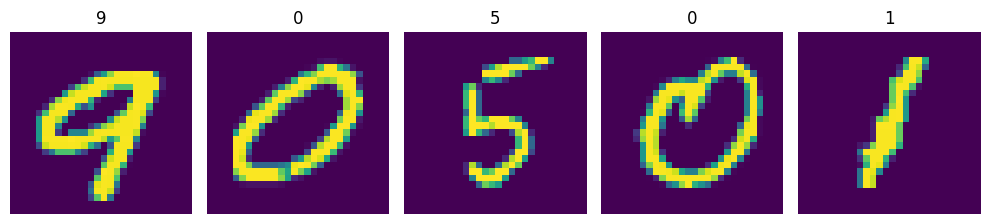

In [6]:
# Vemos el contenido de la base de datos.
# Generamos un conjunto de 5 números aleatorios.
indices_aleatorios = random.sample(range(len(x_train)), 5)

plt.figure(figsize=(10, 5)) # Configuramos el tamaño de la gráfica.

for i, indice in enumerate(indices_aleatorios):
    ax = plt.subplot(1, 5, i + 1) # Queremos 1 renglón, 5 columnas y graficar 5 imágenes.
    plt.imshow(x_train[indice]) # Gráficamos la i-ésima imagen.
    plt.title(y_train[indice]) # Enseñamos que número es el mostrado.
    ax.axis("off")

plt.tight_layout()
plt.show()

In [7]:
# Mostramos la forma de los conjuntos.
print("Forma de datos de entrenamiento: ", x_train.shape)
print("Forma de etiquetas de entrenamiento: ", y_train.shape)
print("Forma de datos de prueba: ", x_test.shape)
print("Forma de etiquetas de prueba: ", y_test.shape)

Forma de datos de entrenamiento:  (60000, 28, 28)
Forma de etiquetas de entrenamiento:  (60000,)
Forma de datos de prueba:  (10000, 28, 28)
Forma de etiquetas de prueba:  (10000,)


In [8]:
# Aplanamos las imagenes de la base de datos.
# La matriz de píxeles la pasamos a un vector fila.
x_trainv = x_train.reshape(60000, 784)
x_testv = x_test.reshape(10000, 784)

# Convertimos los valores de los vectores a números flotantes de 32 bits.
# (4 bytes)
x_trainv = x_trainv.astype('float32')
x_testv = x_testv.astype('float32')

# Escalamos los valores de los vectores (es decir, de los píxeles de la imagen)
# a un rango de [0, 1] para mejorar el entrenamiento de la red.
x_trainv /= 255.
x_testv /= 255.

In [11]:
# Damos el número de clases.
num_classes=10

# Convertimos etiquetas númericas a one hot encoding.
y_trainc = keras.utils.to_categorical(y_train, num_classes)
y_testc = keras.utils.to_categorical(y_test, num_classes)

In [42]:
# Valores de hiperparámetros.
learning_rate = config.learning_rate # Valor de la tasa de aprendizaje.
epochs = config.epochs # Número de épocas.
batch_size = config.batch_size # Número de imágenes que usará cada paso.

In [58]:
# Creamos la red neuronal
model = Sequential()
# Colocamos 784 neuronas de entrada y una capa oculta de 30.
model.add(Dense(60, activation='relu', input_shape=(784,), kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
model.add(Dropout(0.2))
# Colocamos 10 neuronas de sálida.
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 60)             │        47,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │           610 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,710 (186.37 KB)

 Trainable params: 47,710 (186.37 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# Compilación del modelo.
model.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

In [60]:
# Entrenamiento de la red.
history = model.fit(
    x_trainv, y_trainc,
    batch_size=config.batch_size,
    epochs=config.epochs,
    validation_data=(x_testv, y_testc),
    callbacks=[WandbCallback(save_graph=False, save_model=False)]   
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8618 - loss: 0.9262 - val_accuracy: 0.9166 - val_loss: 0.6794
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8937 - loss: 0.7350 - val_accuracy: 0.9322 - val_loss: 0.6096
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9021 - loss: 0.7123 - val_accuracy: 0.9176 - val_loss: 0.6552
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9050 - loss: 0.7055 - val_accuracy: 0.9404 - val_loss: 0.5959
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9075 - loss: 0.6939 - val_accuracy: 0.9300 - val_loss: 0.6136
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9057 - loss: 0.6996 - val_accuracy: 0.9308 - val_loss: 0.6409
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9071 - loss: 0.6970 - val_accuracy: 0.9473 - val_loss: 0.5648
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9067 - loss: 0.6925 - val_accuracy: 

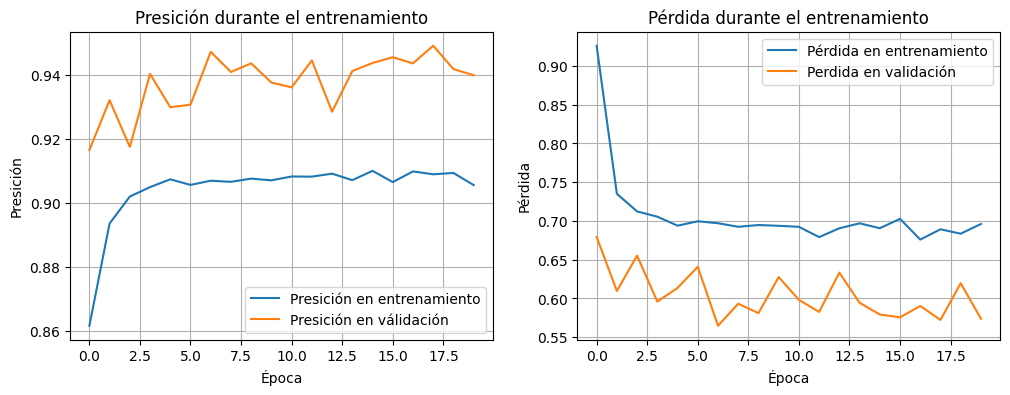

In [61]:
## Gráfica de presición durante el entrenamiento
plt.figure(figsize=(12, 4)) 
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Presición en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Presición en válidación')
plt.title('Presición durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Presición')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2) ## Gráfica de pérdida durante entrenamiento
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Perdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid()
plt.show()